## HOUSE DATA PRICE

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from jucyharo import *

from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Chargement des données

In [74]:
train = pd.read_csv('data/train.csv',index_col="Id")
test = pd.read_csv('data/test.csv',index_col="Id")

Paramètres de visualisation pour jupyter

In [75]:
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

## Exploration des données

In [76]:
# sauvegarde du nombre de ligne du train et du test
n_train = train.shape[0]
n_test = test.shape[0]

# mettre le SalePrice le target dans une variable a part
y_train = train.SalePrice

# suppression de la colonne SalePrice
train.drop(['SalePrice'], axis=1, inplace=True)

In [78]:
#concatenation des data train et test
df_inter = pd.concat((train, test))

## Gestion des données manquantes
Visualisation des données manquantes

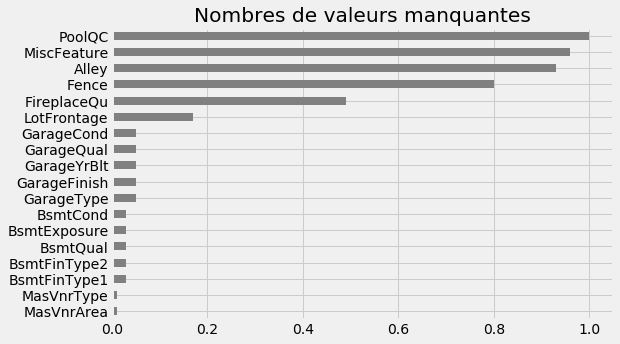

In [6]:
total_na = round((df_inter.isna().sum().sort_values())/df_inter.shape[0], 2)
col_miss_values = (total_na[total_na > 0]).index
total_na[col_miss_values].plot(kind='barh',color='grey',figsize=(8,5),title="Nombres de valeurs manquantes")

On décide de supprimer les colonnes contenant plus de 15% de valeurs manquantes

In [7]:
cols_low_na = total_na[total_na < 0.15]
df_inter = df_inter[cols_low_na.index]

## Gestion des valeurs manquantes
- Que faire du GarageYrBlt ?
- Bsmt => Vérifier qu'il  n'y a pas de basement

### Question 1
Les variables restantes sont-elles corrélées à notre prédiction ? -> Visualisation boxplot pour les qualitatives et scatterplot pour les quantitatives ( --> matrice de corrélation )<br>
### Question 2
Est-ce que des variables nous apporte la même information ? -> Visualisation plot de corrélation ( --> matrice de corrélation )

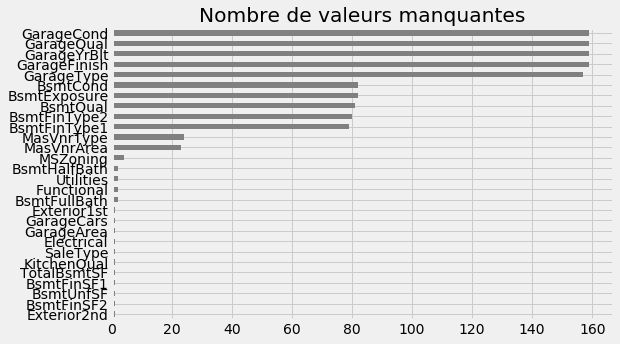

In [8]:
total_na = df_inter.isna().sum().sort_values()
total_na[total_na > 0].plot(kind='barh',color='grey',figsize=(8,5),title="Nombre de valeurs manquantes")

### ( A CONFIRMER )
Le nombre de valeurs manquantes sont les mêmes pour les variables *Garage_*. Le manque d'informations provient de l'inexistence du Garage.
<br><br>
On décide de remplacer les n/a qualitatifs par un label "N/A"

In [9]:
# cols_replace_na_cat = ["GarageCond","GarageType","GarageFinish","GarageQual"]
# df_train[cols_replace_na_cat] = df_train[cols_replace_na_cat].fillna('N/A')

In [10]:
cols_replace_na_cat = ["GarageCond","GarageType","GarageFinish","GarageQual"]
for i in cols_replace_na_cat:
    df_inter[i].fillna('N/A', inplace=True)

In [11]:
cols_replace_na_num =['GarageCars','GarageYrBlt','MasVnrArea','GarageArea']
for i in cols_replace_na_num:
    df_inter[i].fillna(0, inplace=True)

## Reconstitution de la data

In [45]:
train.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460],
           dtype='int64', name='Id', length=1460)

In [57]:
## Cette méthode permet d'éviter les erreurs en cas de lignes supprimées
# Les index doivent correspondres à l'id des ventes (voir le chargement de données)
# Ne peux pas être viable si une réinitisalisation des index est efféctuée

is_index_train = df_inter.index.isin(train.index)
is_index_test = df_inter.index.isin(test.index)

# reconstitution test nettoyé
test_clean = df_inter[is_index_test]

# reconstitution train nettoyé + prix
train_clean = df_inter[is_index_train]                     
train_clean = pd.merge(train_clean, y_train.to_frame(), left_index=True, right_index=True)

## Séléction de features
Visualisations des corrélations

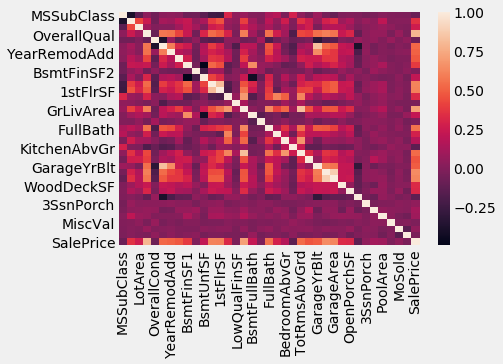

In [58]:
sns.heatmap(train_clean.corr())

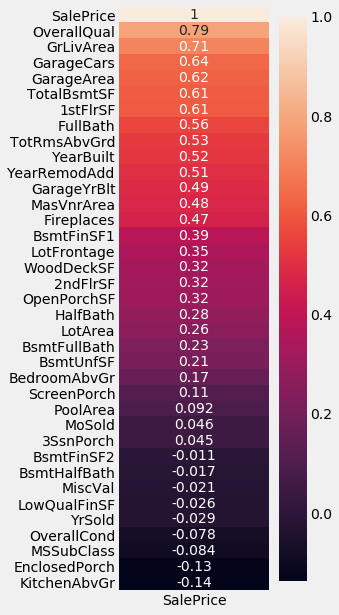

In [59]:
corr_price = train_clean.corr()[['SalePrice']].sort_values('SalePrice',ascending=False)
plt.figure(figsize=(3,10))
sns.heatmap(corr_price,annot=True)

On garde les variables quantitatives corrélées à plus de 25%

In [60]:
corr_price = train_clean.corr()['SalePrice']
cols_features = corr_price[corr_price > 0.25].index
train_clean = train_clean[cols_features]

In [71]:
train_clean.isna().sum()[train_clean[cols_features].isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

## Création de features

## Transformations de valeurs

## Gestion des outliers

## Modèle d'apprentissage
- Définir un seuil final pour le test_size
- On a temporairement retiré *GarageYrBlt* et *MasVnrArea* dû aux valeurs manquantes non traitées

In [68]:
Y = train_clean['SalePrice']
X = train_clean.drop(['SalePrice'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=100)
lm = LinearRegression()
lm.fit(X_train,y_train)
X_train
lm.predict(X_test)
lm.score(X_test,y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').